In [1]:
import numpy as np
import pandas as pd
from main import PredictChurn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read data

In [2]:
df_usage = pd.read_csv('train/app_usage.csv') # pd.read_csv('test/test_app_usage.csv') 
df_visits = pd.read_csv('train/web_visits.csv')
df_claims = pd.read_csv('train/claims.csv')
df_churn_labels = pd.read_csv('train/churn_labels.csv')

In [3]:
df_claims.head()

,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14
2,1,J00,2025-07-12
3,1,M54.5,2025-07-01
4,1,I10,2025-07-12


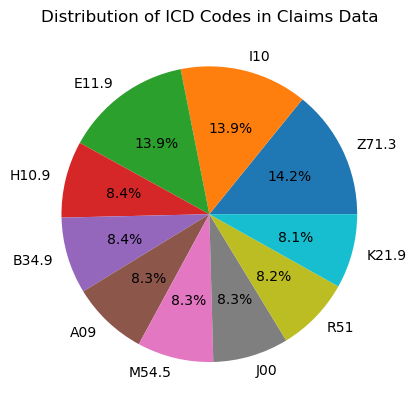

In [4]:

labels = df_claims['icd_code'].value_counts().index
plt.pie(df_claims['icd_code'].value_counts(), labels=labels, autopct='%1.1f%%');
plt.title('Distribution of ICD Codes in Claims Data')
plt.show()

In [5]:
df_churn_labels.head()

,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0
2,3,2024-09-27,0,0
3,4,2024-04-16,1,0
4,5,2024-03-12,0,1


In [6]:
corr_outreach_churn = np.corrcoef(df_churn_labels['churn'], df_churn_labels['outreach'])[0, 1]
print(f"Correlation between Outreach and Churn: {corr_outreach_churn:.3f}")

Correlation between Outreach and Churn: -0.016


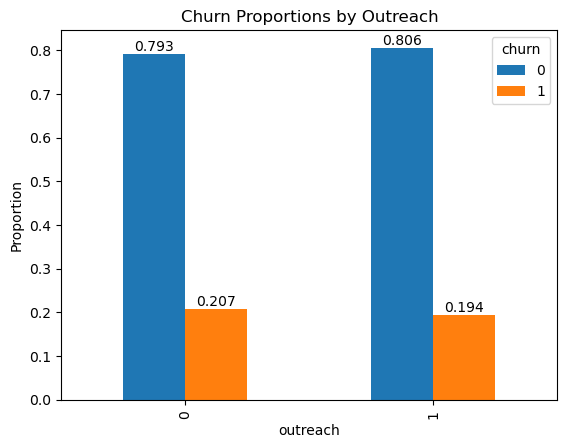

In [7]:
outreach_churn = df_churn_labels.groupby('outreach')['churn'].value_counts(normalize=True).unstack()
ax = outreach_churn.plot(kind='bar', stacked=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Churn Proportions by Outreach')
plt.ylabel('Proportion')
plt.show()

In [8]:
from statsmodels.stats.proportion import proportions_ztest

n_no = len(df_churn_labels[df_churn_labels['outreach'] == 0])
churn_no = df_churn_labels[df_churn_labels['outreach'] == 0]['churn'].sum()
n_yes = len(df_churn_labels[df_churn_labels['outreach'] == 1])
churn_yes = df_churn_labels[df_churn_labels['outreach'] == 1]['churn'].sum()

z_stat, p_value = proportions_ztest([churn_no, churn_yes], [n_no, n_yes])

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    if churn_rate_yes < churn_rate_no:
        print("Outreach significantly reduces churn.")
    else:
        print("Outreach significantly increases churn.")
else:
    print("No significant difference in churn rates.")

Z-statistic: 1.636
P-value: 0.102
No significant difference in churn rates.
